In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import argparse
import os

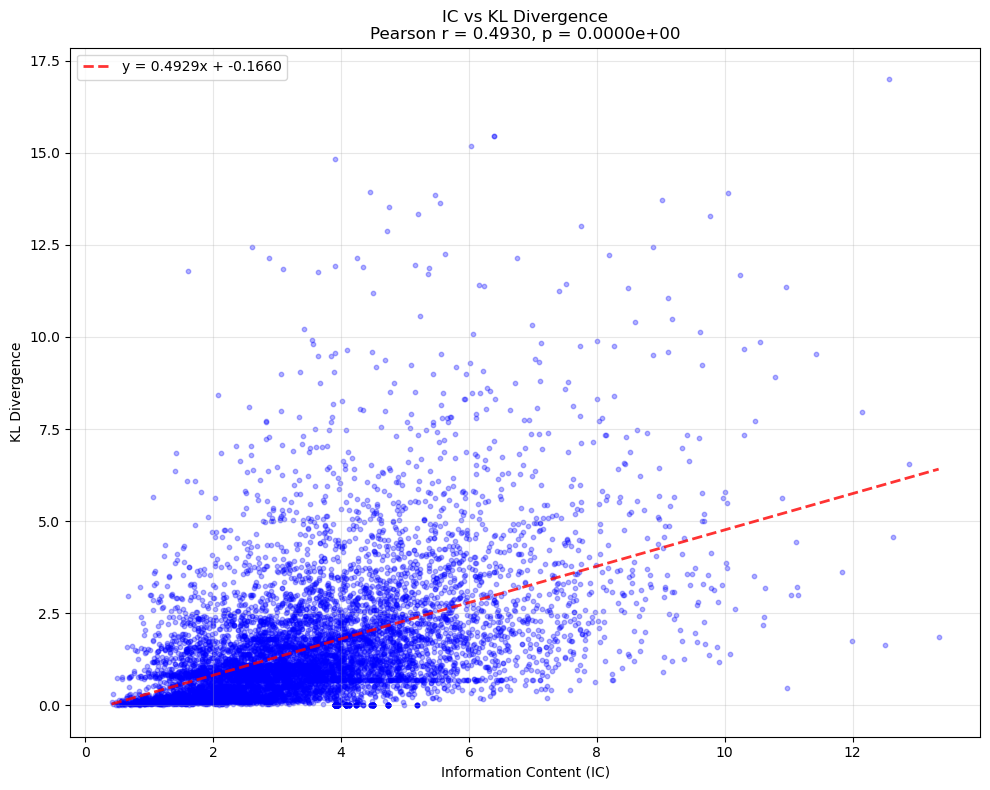

(array([3.89892879, 3.95872344, 2.87298317, ..., 1.81433476, 3.23035635,
        0.7009855 ], shape=(9101,)),
 array([0.        , 0.69316368, 1.79177604, ..., 0.07092561, 2.08511462,
        0.04149631], shape=(9101,)),
 np.float64(0.49299839059493844))

In [3]:
# Load and analyze pickle file with minimal output - only IC vs KL plot
pickle_path = "out/bach_chorals/surprises/largeWestern_wt_bach/data/largeWestern_wt_bach_quantization_24_maxOrder_20_viewpoints_pitch_length.pickle"

with open(pickle_path, 'rb') as f:
    data = pickle.load(f)

all_ic = []
all_kl = []

for filename, values in data.items():
    if filename == "info":
        continue
        
    ic_values = values[0]
    kl_values = values[2]
    
    valid_pairs = [(ic, kl) for ic, kl in zip(ic_values, kl_values) 
                   if ic is not None and kl is not None]
    
    if valid_pairs:
        for ic, kl in valid_pairs:
            all_ic.append(ic)
            all_kl.append(kl)

all_ic = np.array(all_ic)
all_kl = np.array(all_kl)

# Calculate correlation
correlation, p_value = pearsonr(all_ic, all_kl)

# Single plot: IC vs KL with regression line
plt.figure(figsize=(10, 8))
plt.scatter(all_ic, all_kl, alpha=0.3, s=10, c='blue')
plt.xlabel('Information Content (IC)')
plt.ylabel('KL Divergence')
plt.title(f'IC vs KL Divergence\nPearson r = {correlation:.4f}, p = {p_value:.4e}')

# Add regression line
z = np.polyfit(all_ic, all_kl, 1)
p = np.poly1d(z)
x_line = np.linspace(all_ic.min(), all_ic.max(), 100)
plt.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label=f'y = {z[0]:.4f}x + {z[1]:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

all_ic, all_kl, correlation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pickle
import random

# Load the evolution data with all metrics
evolution_path = "out/bach_chorals/evolution/bach_chorals_all_metrics.pickle"

with open(evolution_path, 'rb') as f:
    data = pickle.load(f)

# Extract data
note_counter = data['note_counter']
matrix_ic = data['matrix_ic']
matrix_entropy = data['matrix_entropy']
matrix_kl = data['matrix_kl']
test_pieces = data['test_pieces']

print(f"Data shape: {matrix_ic.shape}")
print(f"Training steps: {matrix_ic.shape[0]}")
print(f"Test pieces: {matrix_ic.shape[1]}")

Data shape: (782, 20)
Training steps: 782
Test pieces: 20


Total data points: 15640
IC range: 2.025 to 36.904
KL range: 0.915 to 1.995
Correlation: 0.1186 (p=3.90e-50)

Training phase breakdown:
Begin: steps 0-259 (5200 points)
Middle: steps 260-520 (5220 points)
Late: steps 521-781 (5220 points)

Phase correlations:
Begin: -0.0319 (p=2.14e-02)
Middle: 0.3383 (p=6.55e-140)
Late: 0.3542 (p=3.62e-154)


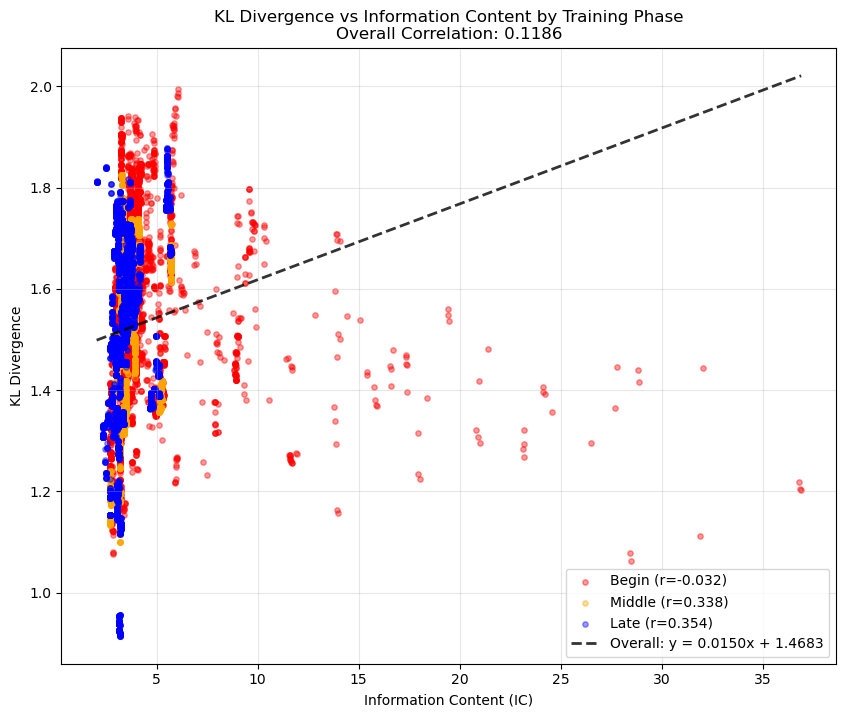

In [5]:
# Flatten matrices to get all data points for correlation analysis
all_ic = matrix_ic.flatten()
all_kl = matrix_kl.flatten()

print(f"Total data points: {len(all_ic)}")
print(f"IC range: {all_ic.min():.3f} to {all_ic.max():.3f}")
print(f"KL range: {all_kl.min():.3f} to {all_kl.max():.3f}")

# Calculate correlation
correlation, p_value = pearsonr(all_ic, all_kl)
print(f"Correlation: {correlation:.4f} (p={p_value:.2e})")

# Divide training steps into 3 parts: begin, middle, late
n_steps = matrix_ic.shape[0]
begin_end = n_steps // 3
middle_end = 2 * n_steps // 3

begin_ic = matrix_ic[:begin_end, :].flatten()
begin_kl = matrix_kl[:begin_end, :].flatten()

middle_ic = matrix_ic[begin_end:middle_end, :].flatten()
middle_kl = matrix_kl[begin_end:middle_end, :].flatten()

late_ic = matrix_ic[middle_end:, :].flatten()
late_kl = matrix_kl[middle_end:, :].flatten()

print(f"\nTraining phase breakdown:")
print(f"Begin: steps 0-{begin_end-1} ({len(begin_ic)} points)")
print(f"Middle: steps {begin_end}-{middle_end-1} ({len(middle_ic)} points)")
print(f"Late: steps {middle_end}-{n_steps-1} ({len(late_ic)} points)")

# Calculate correlations for each phase
begin_corr, begin_p = pearsonr(begin_ic, begin_kl)
middle_corr, middle_p = pearsonr(middle_ic, middle_kl)
late_corr, late_p = pearsonr(late_ic, late_kl)

print(f"\nPhase correlations:")
print(f"Begin: {begin_corr:.4f} (p={begin_p:.2e})")
print(f"Middle: {middle_corr:.4f} (p={middle_p:.2e})")
print(f"Late: {late_corr:.4f} (p={late_p:.2e})")

# Create scatter plot with different colors for each phase
plt.figure(figsize=(10, 8))

plt.scatter(begin_ic, begin_kl, alpha=0.4, s=15, color='red', label=f'Begin (r={begin_corr:.3f})')
plt.scatter(middle_ic, middle_kl, alpha=0.4, s=15, color='orange', label=f'Middle (r={middle_corr:.3f})')
plt.scatter(late_ic, late_kl, alpha=0.4, s=15, color='blue', label=f'Late (r={late_corr:.3f})')

plt.xlabel('Information Content (IC)')
plt.ylabel('KL Divergence')
plt.title(f'KL Divergence vs Information Content by Training Phase\nOverall Correlation: {correlation:.4f}')

# Add trend line for overall data
z = np.polyfit(all_ic, all_kl, 1)
poly_func = np.poly1d(z)
x_line = np.linspace(all_ic.min(), all_ic.max(), 100)
plt.plot(x_line, poly_func(x_line), "k--", alpha=0.8, linewidth=2, 
         label=f'Overall: y = {z[0]:.4f}x + {z[1]:.4f}')

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [6]:
small_path = "out/bach_test/surprises/bach_train_1-3/data/bach_train_1-3_quantization_24_maxOrder_20_viewpoints_pitch_length.pickle"

medium_path = "out/bach_test/surprises/bach_train_2-3/data/bach_train_2-3_quantization_24_maxOrder_20_viewpoints_pitch_length.pickle"

large_path = "out/bach_test/surprises/bach_train_3-3/data/bach_train_3-3_quantization_24_maxOrder_20_viewpoints_pitch_length.pickle"

large_western_path = "out/bach_test/surprises/largeWestern_wt_bach/data/largeWestern_wt_bach_quantization_24_maxOrder_20_viewpoints_pitch_length.pickle"

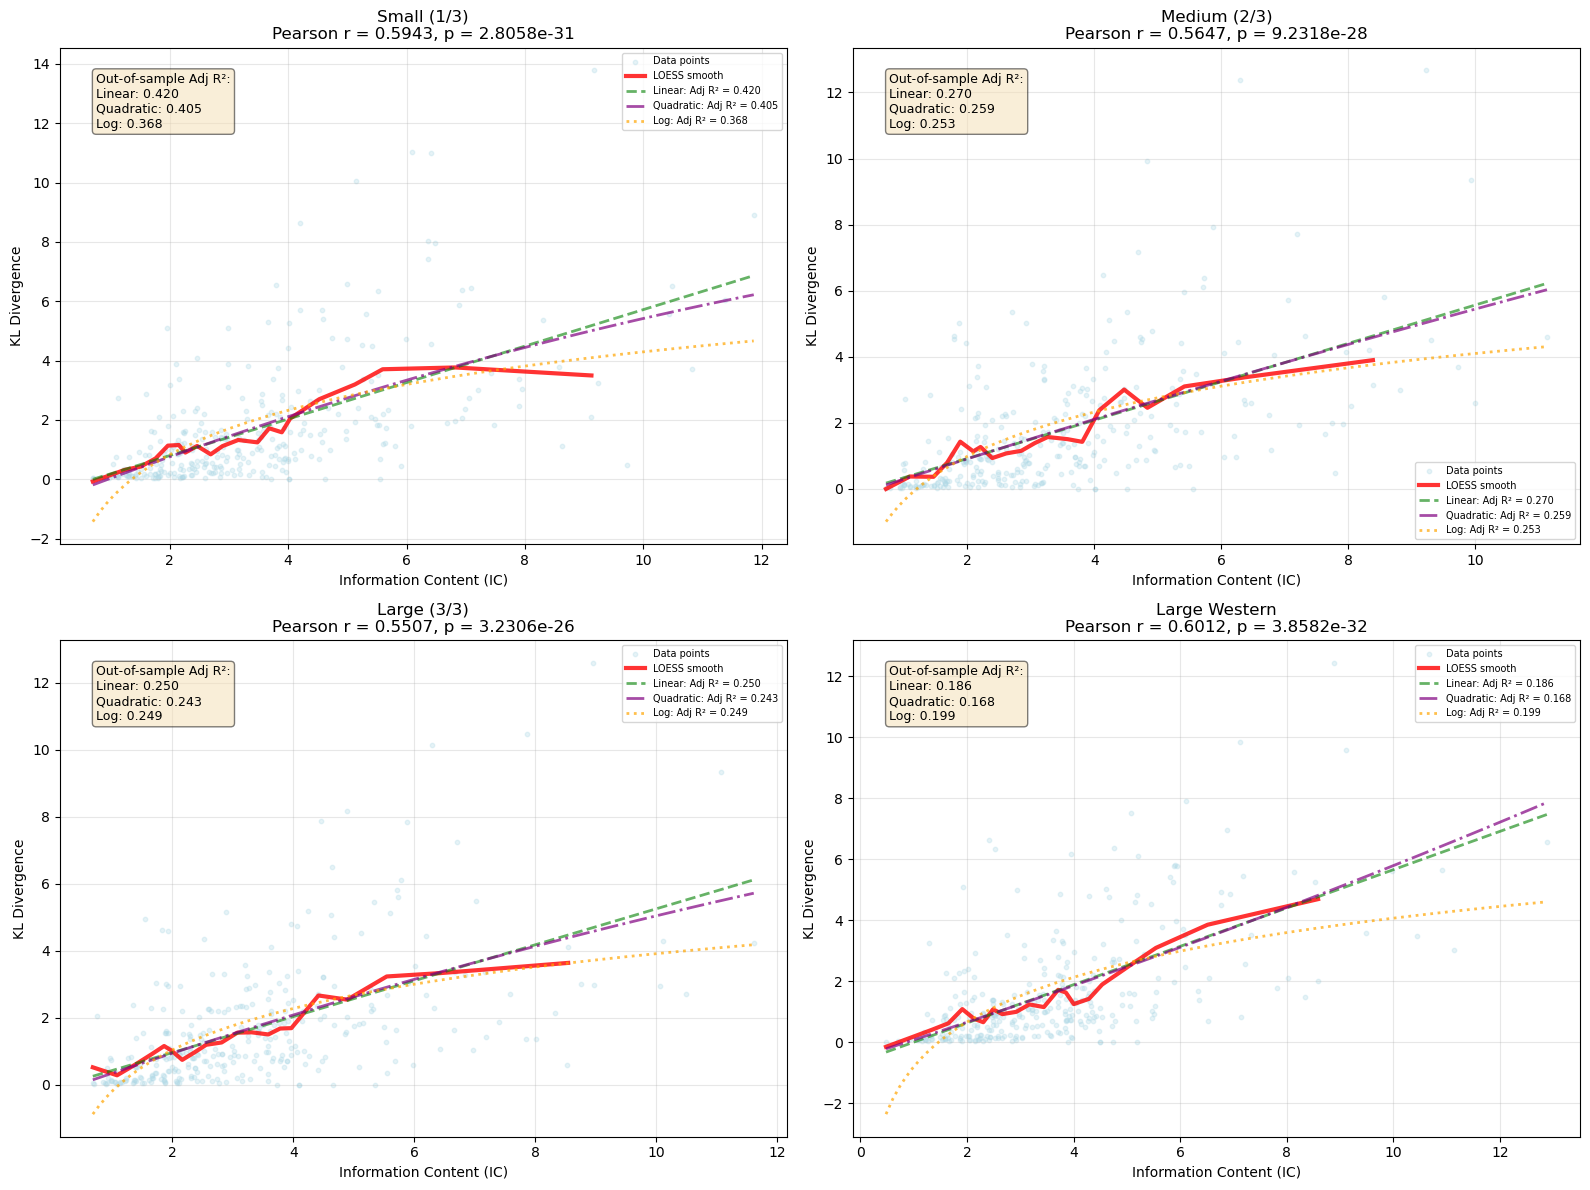

In [9]:
# Create subplot figure for all four datasets with sample-external evaluation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

paths = [small_path, medium_path, large_path, large_western_path]
titles = ['Small (1/3)', 'Medium (2/3)', 'Large (3/3)', 'Large Western']

for idx, (pickle_path, title) in enumerate(zip(paths, titles)):
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)

    all_ic = []
    all_kl = []

    for filename, values in data.items():
        if filename == "info":
            continue
            
        ic_values = values[0]
        kl_values = values[2]
        
        valid_pairs = [(ic, kl) for ic, kl in zip(ic_values, kl_values) 
                       if ic is not None and kl is not None]
        
        if valid_pairs:
            for ic, kl in valid_pairs:
                all_ic.append(ic)
                all_kl.append(kl)

    all_ic = np.array(all_ic)
    all_kl = np.array(all_kl)

    # Calculate correlation
    correlation, p_value = pearsonr(all_ic, all_kl)

    # Train/test split for out-of-sample evaluation
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.metrics import r2_score
    
    X = all_ic.reshape(-1, 1)
    y = all_kl
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Plot on subplot
    ax = axes[idx]
    ax.scatter(all_ic, all_kl, alpha=0.3, s=10, c='lightblue', label='Data points')
    
    # LOESS smoothing on full data for visualization
    from scipy.interpolate import interp1d
    
    # Sort by IC for smooth curve
    sorted_indices = np.argsort(all_ic)
    ic_sorted = all_ic[sorted_indices]
    kl_sorted = all_kl[sorted_indices]
    
    # Use local polynomial regression (LOESS approximation)
    window_size = max(50, len(all_ic) // 20)
    ic_smooth = []
    kl_smooth = []
    
    for i in range(0, len(ic_sorted), window_size//3):
        start_idx = max(0, i - window_size//2)
        end_idx = min(len(ic_sorted), i + window_size//2)
        
        if end_idx - start_idx < 10:
            continue
            
        local_ic = ic_sorted[start_idx:end_idx]
        local_kl = kl_sorted[start_idx:end_idx]
        
        poly_features = PolynomialFeatures(degree=2)
        ic_poly = poly_features.fit_transform(local_ic.reshape(-1, 1))
        reg = LinearRegression().fit(ic_poly, local_kl)
        
        center_ic = ic_sorted[i] if i < len(ic_sorted) else ic_sorted[-1]
        center_ic_poly = poly_features.transform([[center_ic]])
        center_kl = reg.predict(center_ic_poly)[0]
        
        ic_smooth.append(center_ic)
        kl_smooth.append(center_kl)
    
    # Plot LOESS curve
    if len(ic_smooth) > 1:
        ax.plot(ic_smooth, kl_smooth, 'r-', linewidth=3, alpha=0.8, label='LOESS smooth')
    
    # Linear regression with out-of-sample evaluation
    model_linear = LinearRegression().fit(X_train, y_train)
    y_pred_linear = model_linear.predict(X_test)
    r2_linear = r2_score(y_test, y_pred_linear)
    p_linear = 1  # Number of predictors (excluding intercept)
    adj_r2_linear = 1 - (1 - r2_linear) * (len(y_test) - 1) / (len(y_test) - p_linear - 1)
    
    # Plot linear regression line
    x_line = np.linspace(all_ic.min(), all_ic.max(), 100)
    y_line_linear = model_linear.predict(x_line.reshape(-1, 1))
    ax.plot(x_line, y_line_linear, "g--", alpha=0.6, linewidth=2, 
            label=f'Linear: Adj R² = {adj_r2_linear:.3f}')
    
    # Quadratic polynomial with out-of-sample evaluation
    poly_features_quad = PolynomialFeatures(degree=2)
    X_train_quad = poly_features_quad.fit_transform(X_train)
    X_test_quad = poly_features_quad.transform(X_test)
    model_quad = LinearRegression().fit(X_train_quad, y_train)
    y_pred_quad = model_quad.predict(X_test_quad)
    r2_quad = r2_score(y_test, y_pred_quad)
    p_quad = 2  # Number of predictors: x and x^2
    adj_r2_quad = 1 - (1 - r2_quad) * (len(y_test) - 1) / (len(y_test) - p_quad - 1)
    
    # Plot quadratic regression line
    x_line_quad = poly_features_quad.transform(x_line.reshape(-1, 1))
    y_line_quad = model_quad.predict(x_line_quad)
    ax.plot(x_line, y_line_quad, 'purple', alpha=0.7, linewidth=2, linestyle='-.',
            label=f'Quadratic: Adj R² = {adj_r2_quad:.3f}')
    
    # Logarithmic fitting with out-of-sample evaluation
    # Filter positive IC values in training set
    train_mask_pos = X_train.flatten() > 0
    test_mask_pos = X_test.flatten() > 0
    
    if np.sum(train_mask_pos) > 10 and np.sum(test_mask_pos) > 5:
        X_train_log = np.log(X_train[train_mask_pos])
        y_train_log = y_train[train_mask_pos]
        X_test_log = np.log(X_test[test_mask_pos])
        y_test_log = y_test[test_mask_pos]
        
        model_log = LinearRegression().fit(X_train_log.reshape(-1, 1), y_train_log)
        y_pred_log = model_log.predict(X_test_log.reshape(-1, 1))
        r2_log = r2_score(y_test_log, y_pred_log)
        p_log = 1  # Number of predictors
        n_pos_test = np.sum(test_mask_pos)
        adj_r2_log = 1 - (1 - r2_log) * (n_pos_test - 1) / (n_pos_test - p_log - 1)
        
        # Plot logarithmic regression line
        x_pos = x_line[x_line > 0]
        if len(x_pos) > 0:
            y_line_log = model_log.predict(np.log(x_pos).reshape(-1, 1))
            ax.plot(x_pos, y_line_log, 'orange', alpha=0.7, linewidth=2, linestyle=':',
                    label=f'Log: Adj R² = {adj_r2_log:.3f}')
    
    ax.set_xlabel('Information Content (IC)')
    ax.set_ylabel('KL Divergence')
    ax.set_title(f'{title}\nPearson r = {correlation:.4f}, p = {p_value:.4e}')
    ax.legend(fontsize=7, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add text box with all adjusted R² values (out-of-sample)
    textstr = f'Out-of-sample Adj R²:\nLinear: {adj_r2_linear:.3f}\nQuadratic: {adj_r2_quad:.3f}'
    if 'adj_r2_log' in locals():
        textstr += f'\nLog: {adj_r2_log:.3f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

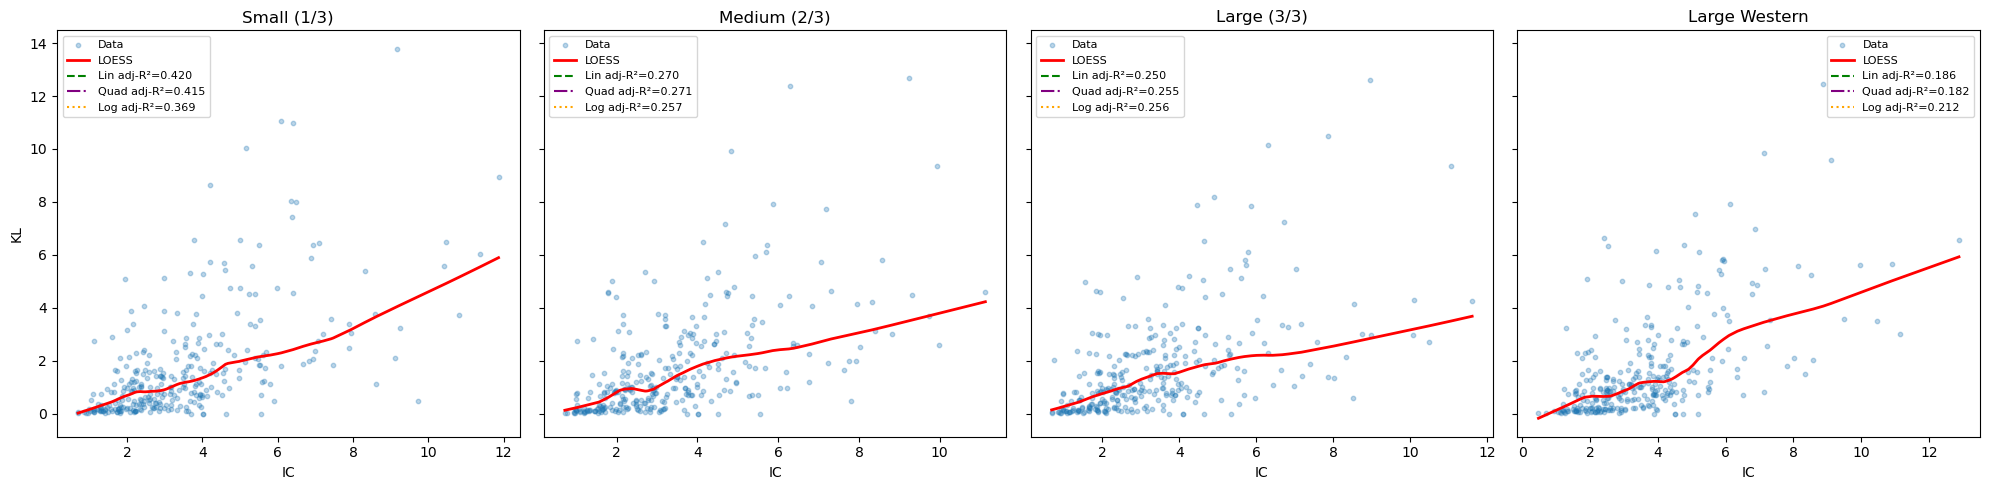

Adjusted R² 比较：
                 Linear     Poly2       Log
Small (1/3)    0.419661  0.415062  0.368506
Medium (2/3)   0.270175  0.271039  0.257037
Large (3/3)    0.250072  0.255371  0.255753
Large Western  0.186011  0.181866  0.211635


In [8]:
# ——— Cell X：阶段化 IC–KL 分析 ———
import pickle, numpy as np, matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

# 1. 载入数据集路径
paths = [small_path, medium_path, large_path, large_western_path]
phase_labels = ['Small (1/3)', 'Medium (2/3)', 'Large (3/3)', 'Large Western']

# 2. 循环分析每个阶段
results = {lab: {} for lab in phase_labels}
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for pickle_path, lab, ax in zip(paths, phase_labels, axes):
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)

    all_ic = []
    all_kl = []

    for filename, values in data.items():
        if filename == "info":
            continue
            
        ic_values = values[0]
        kl_values = values[2]
        
        valid_pairs = [(ic, kl) for ic, kl in zip(ic_values, kl_values) 
                       if ic is not None and kl is not None]
        
        if valid_pairs:
            for ic, kl in valid_pairs:
                all_ic.append(ic)
                all_kl.append(kl)

    ic_phase = np.array(all_ic)
    kl_phase = np.array(all_kl)

    # 散点 + LOESS
    ax.scatter(ic_phase, kl_phase, s=10, alpha=0.3, label='Data')
    lo = lowess(kl_phase, ic_phase, frac=0.3)
    ax.plot(lo[:,0], lo[:,1], 'r-', lw=2, label='LOESS')

    # 拆分训练/测试
    X = ic_phase.reshape(-1, 1)
    y = kl_phase
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=0)

    # 线性模型
    m_lin = LinearRegression().fit(Xtr, ytr)
    ypred = m_lin.predict(Xte)
    r2 = r2_score(yte, ypred)
    adj = 1 - (1-r2)*(len(yte)-1)/(len(yte)-Xte.shape[1]-1)
    results[lab]['Linear'] = adj
    ax.plot([], [], 'g--', label=f'Lin adj-R²={adj:.3f}')

    # 二次多项式
    pf2 = PolynomialFeatures(2)
    X2tr = pf2.fit_transform(Xtr)
    m_quad = LinearRegression().fit(X2tr, ytr)
    y2pred = m_quad.predict(pf2.transform(Xte))
    r2q = r2_score(yte, y2pred)
    adjq = 1 - (1-r2q)*(len(yte)-1)/(len(yte)-Xte.shape[1]-1)
    results[lab]['Poly2'] = adjq
    ax.plot([], [], 'purple', linestyle='-.', label=f'Quad adj-R²={adjq:.3f}')

    # 对数模型（IC>0）
    mask = ic_phase>0
    log_ic = np.log(ic_phase[mask]).reshape(-1,1)
    log_kl = kl_phase[mask]
    m_log = LinearRegression().fit(log_ic, log_kl)
    # 在测试集上 eval
    mask_te = Xte.flatten()>0
    Xlog_te = np.log(Xte[mask_te]).reshape(-1,1)
    ylog_pred = m_log.predict(Xlog_te)
    r2l = r2_score(yte[mask_te], ylog_pred)
    adjl = 1 - (1-r2l)*(len(yte[mask_te])-1)/(len(yte[mask_te])-1-1)
    results[lab]['Log'] = adjl
    ax.plot([], [], 'orange', linestyle=':', label=f'Log adj-R²={adjl:.3f}')

    ax.set_title(lab)
    ax.set_xlabel('IC'); ax.legend(fontsize=8)

axes[0].set_ylabel('KL')
plt.tight_layout()
plt.show()

# 3. 汇总展示
import pandas as pd
df = pd.DataFrame(results).T
print("Adjusted R² 比较：")
print(df)